## 读取图像，二值化
#### 1、方向检测、旋转？
#### 2、基本信息点查找 得到位置信息
#### 3、图像分割

In [41]:
import aircv as ac
import skimage.morphology as sm  # 膨胀与腐蚀
import matplotlib.pyplot as plt
from skimage import io,color
from skimage import data,filters  # filters  阈值处理
import numpy as np
import cv2  #  打开图像不会 旋转img=cv2.imread(file, 1)
file = "/Users/zhoudaoxian/Documents/frame/沈13810387085.jpg"
# img = io.imread(file, True)
img=cv2.imread(file, 1)

# img=color.rgb2gray(io.imread('/Users/zhoudaoxian/Documents/RdataCode/bg.png' ))

ImportError: No module named aircv

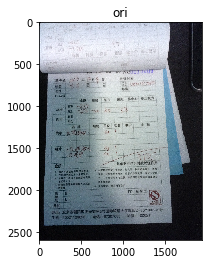

In [11]:
# img90=np.rot90(img)
def show_fig(title, sub, size,img):
    plt.figure(title, figsize=size)
    plt.subplot(sub)
    plt.imshow(img, plt.cm.gray)
    plt.title(title) # 图像题目
    plt.show()
show_fig("ori",(111), (4,4), img)
# show_fig("ori", (20,20), img)

### 对灰度图像腐蚀后，文字增强了

In [12]:
imggray=cv2.imread(file, 0)  # 灰度图，，二值化图像

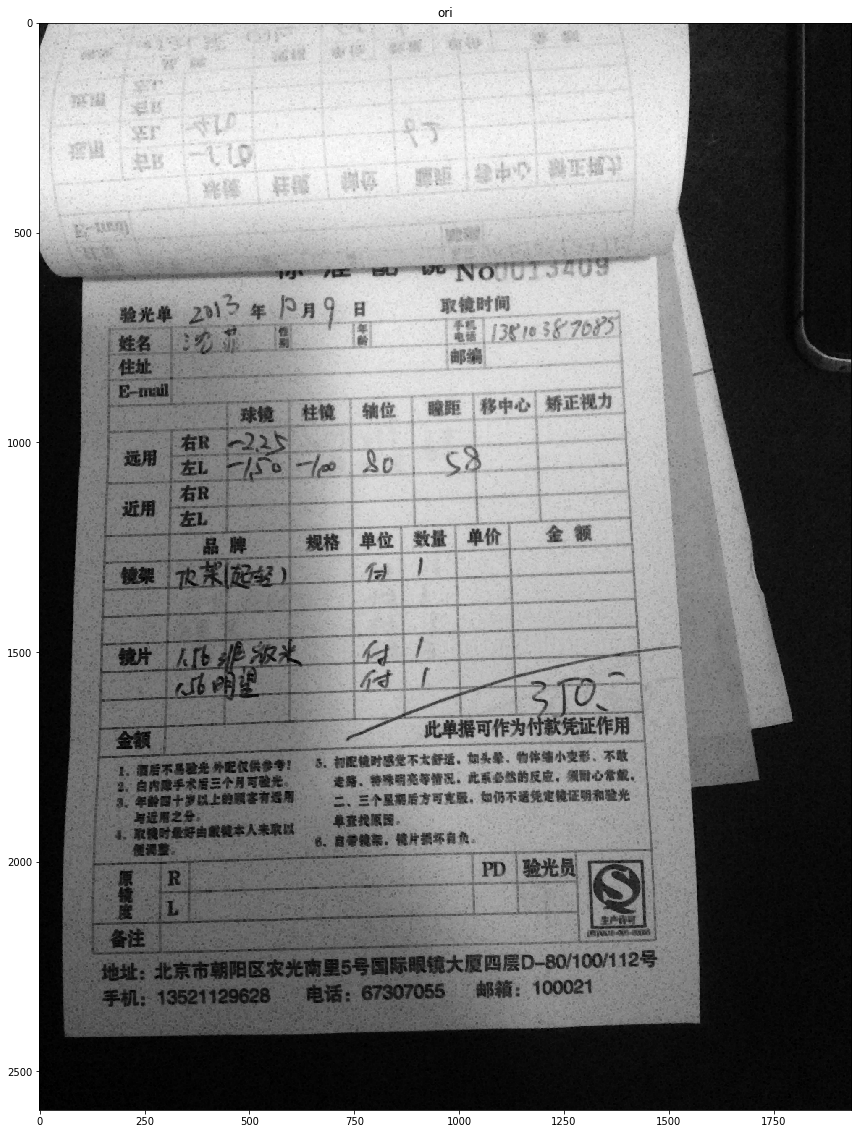

In [13]:
dst1=sm.erosion(imggray,sm.square(4)) #用边长为5的正方形滤波器进行膨胀滤波
show_fig("ori",111, (20,20), dst1) 

2、边沿检测（监测图像边沿信息）

##  膨胀、腐蚀操作 
提取横线竖线的思路，不知是否有必要

## 限制对比度的自适应直方图均衡化 增强

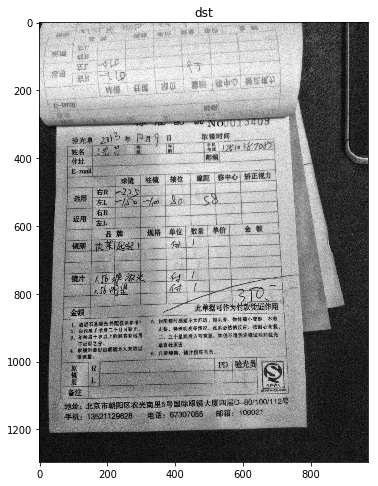

In [14]:
img = cv2.imread(file, 0)
img = cv2.resize(img, None, fx=0.5, fy=0.5)
# 创建CLAHE对象
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(30, 30))
# 限制对比度的自适应阈值均衡化
dst = clahe.apply(img)
# 分别显示原图，CLAHE，HE
# show_fig("img",131, (20,20), img) 
show_fig("dst",132, (20,20), dst) 

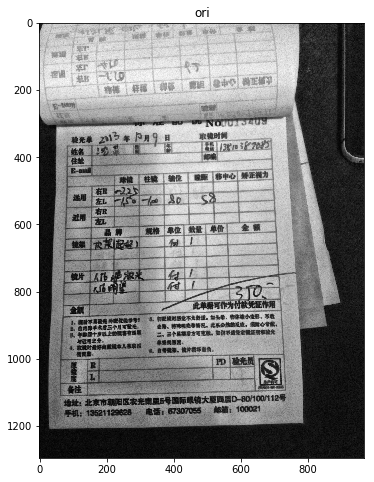

In [15]:
# 对增强后的图像消除，扩大
dst1=sm.erosion(dst,sm.square(3)) #用边长为5的正方形滤波器进行膨胀滤波
show_fig("ori",111, (8,8), dst1) 

### 由图可知，进行分离会更加清晰 滤波，分离  二值化 神级操作

In [ ]:
#

#### 2. Preprocess
利用数学形态学（Morphology）进行预处理。

这个过程很重要，是文字区域检测效果好坏的核心代码，尤其是一下几个参数：

膨胀的核函数大小，这里用了 30 x 9，可以调节
腐蚀的核函数大小，这里用了 24 x 6，可以调节

In [16]:
def preprocess(gray):
    # 1. Sobel算子，x方向求梯度
    sobel = cv2.Sobel(gray, cv2.CV_8U, 1, 0, ksize = 3)
    # 2. 二值化
    ret, binary = cv2.threshold(sobel, 0, 255, cv2.THRESH_OTSU+cv2.THRESH_BINARY)
 
    # 3. 膨胀和腐蚀操作的核函数
    element1 = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 4))
    element2 = cv2.getStructuringElement(cv2.MORPH_RECT, (6, 6))
 
    # 4. 膨胀一次，让轮廓突出
    dilation = cv2.dilate(binary, element2, iterations = 1)
 
    # 5. 腐蚀一次，去掉细节，如表格线等。注意这里去掉的是竖直的线
    erosion = cv2.erode(dilation, element1, iterations = 1)
 
    # 6. 再次膨胀，让轮廓明显一些
    dilation2 = cv2.dilate(erosion, element1, iterations = 3)
 
    return dilation2


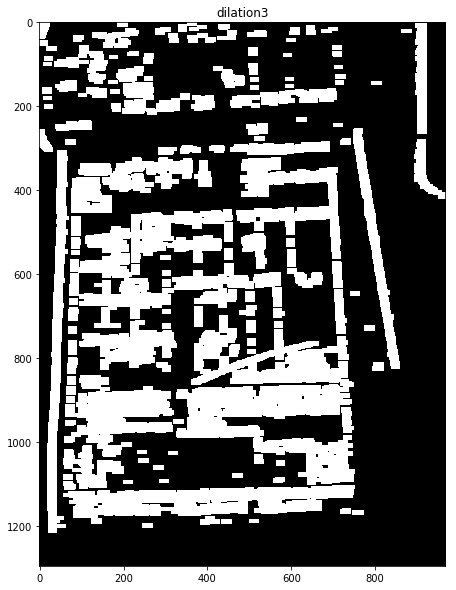

In [21]:
dilation2 = preprocess(imggray)
dilation3 = preprocess(dst1)
# show_fig("dilation2",111, (10,10), dilation2)
show_fig("dilation3",111, (10,10), dilation3)

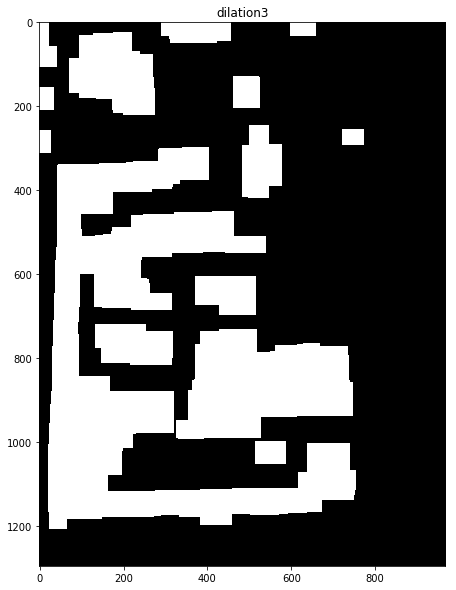

In [38]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 30))          # 定义矩形结构元素
closed = cv2.morphologyEx(dilation3, cv2.MORPH_CLOSE, kernel)       # 闭运算（链接块）
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 40))          # 定义矩形结构元素
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)           # 开运算（去噪点）
# closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)       # 闭运算（链接块）
# opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)           # 开运算（去噪点）

show_fig("dilation3",111, (10,10), opened)

In [18]:
def findTextRegion(img):
    region = []
 
    # 1. 查找轮廓
    contours, hierarchy = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
 
    # 2. 筛选那些面积小的
    for i in range(len(contours)):
        cnt = contours[i]
        # 计算该轮廓的面积
        area = cv2.contourArea(cnt) 
 
        # 面积小的都筛选掉
        if(area < 1000):
            continue
 
        # 轮廓近似，作用很小
        epsilon = 0.001 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)
 
        # 找到最小的矩形，该矩形可能有方向
        rect = cv2.minAreaRect(cnt)
        # box是四个点的坐标
        box = cv2.boxPoints(rect)
        box = np.int0(box)
 
        # 计算高和宽
        height = abs(box[0][1] - box[2][1])
        width = abs(box[0][0] - box[2][0])
 
        # 筛选那些太细的矩形，留下扁的
        if(height > width * 1.2):
            continue
 
        region.append(box)
    return region

In [39]:
region = findTextRegion(opened)
region[0]

array([[ 586, 1052],
       [ 512, 1052],
       [ 512,  997],
       [ 586,  997]])

In [34]:
[region[0]]

[array([[  64, 1205],
        [  21, 1205],
        [  21, 1176],
        [  64, 1176]])]

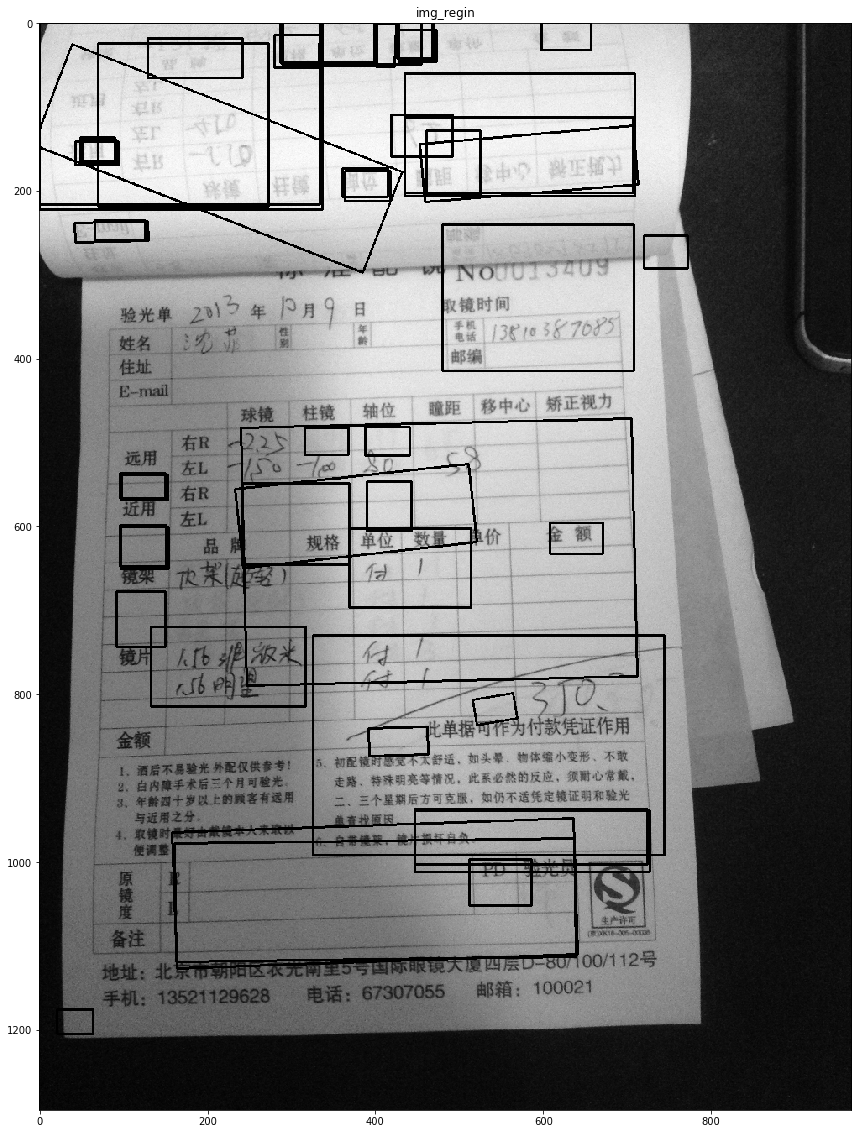

In [40]:
# 4. 用绿线画出这些找到的轮廓
for box in region:
    cv2.drawContours(img, [box], 0, (0, 255, 0), 2)
show_fig("img_regin",111, (20,20), img)


## 傅立叶变换提取轮廓

In [29]:
import cv2
import numpy as np

def Img_Outline(input_dir):
    original_img = cv2.imread(input_dir)
    gray_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray_img, (9, 9), 0)                     # 高斯模糊去噪（设定卷积核大小影响效果）
    _, RedThresh = cv2.threshold(blurred, 165, 255, cv2.THRESH_BINARY)  # 设定阈值165（阈值影响开闭运算效果）
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))          # 定义矩形结构元素
    closed = cv2.morphologyEx(RedThresh, cv2.MORPH_CLOSE, kernel)       # 闭运算（链接块）
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)           # 开运算（去噪点）
    return original_img, gray_img, RedThresh, closed, opened


def findContours_img(original_img, opened):
    image, contours, hierarchy = cv2.findContours(opened, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    c = sorted(contours, key=cv2.contourArea, reverse=True)[1]          # 计算最大轮廓的旋转包围盒
    rect = cv2.minAreaRect(c)
    angle = rect[2]
    print("angle",angle)
    box = np.int0(cv2.boxPoints(rect))
    draw_img = cv2.drawContours(original_img.copy(), [box], -1, (0, 0, 255), 3)
    rows, cols = original_img.shape[:2]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    result_img = cv2.warpAffine(original_img, M, (cols, rows))
    return result_img,draw_img


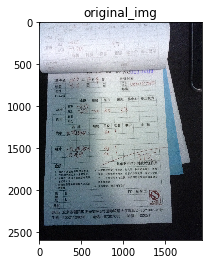

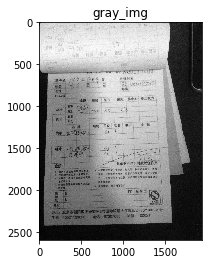

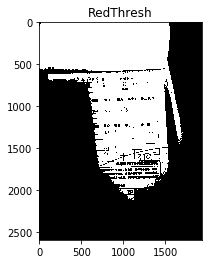

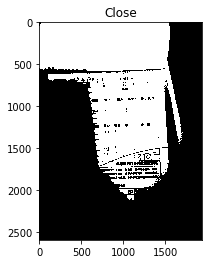

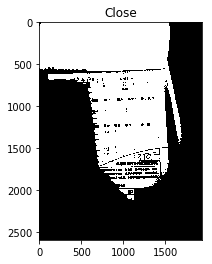

In [36]:
input_dir = file
original_img, gray_img, RedThresh, closed, opened = Img_Outline(input_dir)
# result_img,draw_img = findContours_img(original_img, opened)

show_fig("original_img",size = (4,4), img=original_img)
show_fig("gray_img",size = (4,4), img=gray_img)
show_fig("RedThresh",size = (4,4), img=RedThresh)
show_fig("Close",size = (4,4), img=closed)
show_fig("Close",size = (4,4), img=opened)
# show_fig("draw_img",size = (4,4), img=draw_img)
# show_fig("result_img",size = (4,4), img=result_img)
